In [1]:
# split train and test set of math symbols
import json
import random
import os

random.seed(777)

symbol_images_dir = 'symbol_images/'
terminals = ['+', '-', 'times', 'div', '!'] + list(map(str, list(range(10))))
sym_train_set = {}
sym_val_set = {}
sym_test_set = {}
for tok in terminals:
    imgs = os.listdir(symbol_images_dir + tok)
    random.shuffle(imgs)
    n_train = int(len(imgs) * 0.75)
    n_val = int(len(imgs) * 0.05)
    sym_train_set[tok] = sorted(imgs[:n_train])
    sym_val_set[tok] = sorted(imgs[n_train:n_train+n_val])
    sym_test_set[tok] = sorted(imgs[n_train+n_val:])
    print(tok, len(imgs))
json.dump(sym_train_set, open('sym_train.json', 'w'))
json.dump(sym_val_set, open('sym_val.json', 'w'))
json.dump(sym_test_set, open('sym_test.json', 'w'))

+ 25112
- 33997
times 3251
div 868
! 1300
0 6914
1 26520
2 26141
3 10909
4 7396
5 3545
6 3118
7 2909
8 3068
9 3737


In [2]:
from domain import SYM2PROG
import sys
sys.path.insert(0, "..")
sys.path.insert(0, "../semantics/dreamcoder")

from jointer import AST
import os
import random
from PIL import Image
import json
random.seed(777)

class Iterator:
    def __init__(self, l, shuffle=True):
        if shuffle: 
            random.shuffle(l)
        self.list = l
        self.current = -1
        self.shuffle = shuffle
    
    def next(self):
        self.current += 1
        if self.current == len(self.list):
            self.current = 0
            if self.shuffle:
                random.shuffle(self.list)
        return self.list[self.current]

splits = ['train', 'val', 'test']
split2sym = {}
for split in splits:
    sym_set = {k:Iterator(v) for k,v in json.load(open('sym_%s.json'%split)).items()}
    split2sym[split] = sym_set
    

def render_img(img_paths):
    images = [Image.open(symbol_images_dir + x) for x in img_paths]
    widths, heights = zip(*(i.size for i in images))

    total_width = sum(widths)
    max_height = max(heights)

    new_im = Image.new('RGB', (total_width, max_height))

    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    return new_im

def generate_img_paths(tokens, sym_set):
    img_paths = []
    for tok in tokens:
        if tok == '*': tok = 'times'
        if tok == '/': tok = 'div'
        
        img_name = sym_set[tok].next()
        img_paths.append(os.path.join(tok, img_name))   
        
    return img_paths

In [3]:
min_num = 0
max_num = 10
num_list = list(map(str, range(min_num, max_num)))
nonzero_num_list = [x for x in num_list if x != '0']
op_list = ['+', '-', '*', '/', '!']
nonfactorial_op_list = ['+', '-', '*', '/']

print(num_list)
print(op_list)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
['+', '-', '*', '/', '!']


In [4]:
def enumerate_expression(n_op):
    expressions = [[x] for x in num_list]
    for _ in range(n_op):
        new = []
        for expr in expressions:
            for op in op_list:
                if op == '!':
                    new.append(expr + [op])
                else:
                    for num in num_list:
                        new.append(expr + [op, num])
        expressions = new
    expressions = ["".join(expr) for expr in expressions]
    return expressions

def sample_expression(n_op, n_instances):
    def sample():
        expr = [random.choice(num_list)]
        for _ in range(n_op):
            selected_op = random.choice(op_list)
            expr.append(selected_op)
            if selected_op == '!':
                continue
            else:
                selected_num = random.choice(num_list)
                expr.append(selected_num)
        return "".join(expr)
    
    expressions = set()
    while len(expressions) < n_instances:
        expressions.add(sample())
    return list(expressions)

def generate_expression(n_op, n_instances=None):
    if n_op <= 2:
        expressions = enumerate_expression(n_op)
    else:
        assert n_instances is not None
        expressions = sample_expression(n_op, n_instances)
    random.shuffle(expressions)
    return expressions
    
def eval_expr(expr, head):
    ast = AST(expr, head, SYM2PROG)
    return ast.res()
    
def eval_expr_by_eval(expr):
    expr_for_eval = []
    for symbol in expr:
        if symbol == '!':
            expr_for_eval[-1] = 'math.factorial(' + expr_for_eval[-1] + ')'
        elif symbol == '/':
            expr_for_eval.append('//')
        else:
            expr_for_eval.append(symbol)
#     try:
#         res = eval("".join(expr_for_eval))
#     except OverflowError:
#         res = None
    res = eval("".join(expr_for_eval))
    return res

def parse_expr(expr):
    values = []
    operators = []
    priority = {'+': 0, '-': 0, '*': 1, '/': 1, '!': 2}
    arity = {'+': 2, '-': 2, '*': 2, '/': 2, '!': 1}

    head = [-1] * len(expr)
    for (i,sym) in enumerate(expr):
        if sym.isdigit():
            values.append(i)
        else:
            while len(operators) > 0 and priority[expr[operators[-1]]] >= priority[sym]:
                op = operators.pop()
                for _ in range(arity[expr[op]]):
                    head[values.pop()] = op
                values.append(op)
            operators.append(i)

    while len(operators) > 0:
        op = operators.pop()
        for _ in range(arity[expr[op]]):
            head[values.pop()] = op
        values.append(op)

    
    root_op = values.pop()
    head[root_op] = -1
    assert len(values) == 0

    return head

expr = '6/4+2!'
head = parse_expr(expr)
res = eval_expr(expr, head)
print(expr, res, head)

6/4+2! 4 [1, 3, 1, -1, 5, 3]


In [5]:
expressions = generate_expression(2)
expressions = [(x, parse_expr(x)) for x in expressions]
expressions = [(expr, head, eval_expr(expr, head)) for expr, head in expressions]
print(len(expressions))
print(len([x for x in expressions if x[2] != 0]))
print(len([x for x in expressions if x[2] == 0]))

16810
12822
3988


In [6]:
random.seed(12306)
max_op = 10
max_train_op = 3
max_train = int(1e3)
train_exprs = []
val_exprs = []
test_exprs = []
for n_op in range(max_op + 1):
    expressions = generate_expression(n_op, 2 * max_train)
    print(n_op, len(expressions))
    expressions = [(x, parse_expr(x)) for x in expressions]
    expressions = [(expr, head, eval_expr(expr, head)) for expr, head in expressions]
    if n_op <= max_train_op:
        train_exprs.append(expressions[:max_train])
    val_exprs.append(expressions[:2 * max_train])
    test_exprs.append(expressions[:2 * max_train])
    
split2exprs = {'train': train_exprs, 'val': val_exprs, 'test': test_exprs}
print([(k, sum([len(x) for x in v])) for k, v in split2exprs.items()])

0 10
1 410
2 16810
3 2000
4 2000
5 2000
6 2000
7 2000
8 2000
9 2000
10 2000
[('train', 2420), ('val', 18420), ('test', 18420)]


In [7]:
split = 'train'
dataset = split2exprs[split][-1]
print(len(dataset))
print(dataset[:5])

1000
[('1/1!*7', [1, 4, 3, 1, -1, 4], 7), ('4-9-4+5', [1, 3, 1, 5, 3, -1, 5], 5), ('8/4*0!', [1, 3, 1, -1, 5, 3], 2), ('6+8/1*5', [1, -1, 3, 5, 3, 1, 5], 46), ('1*5+5+0', [1, 3, 1, 5, 3, -1, 5], 10)]


In [8]:
import math

split2dataset = {}
for split in splits:
    sym_set = split2sym[split]
    exprs = split2exprs[split]
    dataset = []
    idx = 0
    for n_op, expr_list in enumerate(exprs):
        n_instance = 10 if n_op > 0 else 100
        if split == 'val':
            n_instance *= 0.1
        for e in expr_list:
            if e[2] is None: continue
            # if the result is 0 and n_op > 0, we only keep 0.1 instances.
            percent = 1
            if e[2] == 0 and n_op == 1 and '-' in e[0]:
                percent = 1
            for _ in range(int(math.ceil(n_instance * percent))):
                img_paths = generate_img_paths(e[0], sym_set)
                sample = {'id': '%s_%08d'%(split, idx), 'img_paths':img_paths, 
                      'expr': e[0], 'head': e[1], 'res': e[2]}
                idx += 1
                dataset.append(sample)
    split2dataset[split] = dataset
    print(split, len(dataset))

train 21930
val 11325
test 113250


In [9]:
dataset = split2dataset['train']
print(len(dataset))
print(len([0 for x in dataset if x['res'] != 0]))
print(len([0 for x in dataset if x['res'] == 0 and len(x['expr']) == 1]))
print(len({x['res'] for x in dataset}))
for i in range(20):
    print(i, len([0 for x in dataset if x['res'] == i]))

print(dataset[:5])

21930
16890
100
132
0 5040
1 2410
2 1310
3 1000
4 1070
5 970
6 890
7 1030
8 940
9 860
10 600
11 380
12 380
13 240
14 270
15 300
16 280
17 170
18 150
19 120
[{'id': 'train_00000000', 'img_paths': ['7/exp17183.jpg'], 'expr': '7', 'head': [-1], 'res': 7}, {'id': 'train_00000001', 'img_paths': ['7/exp35551.jpg'], 'expr': '7', 'head': [-1], 'res': 7}, {'id': 'train_00000002', 'img_paths': ['7/exp39817.jpg'], 'expr': '7', 'head': [-1], 'res': 7}, {'id': 'train_00000003', 'img_paths': ['7/exp54651.jpg'], 'expr': '7', 'head': [-1], 'res': 7}, {'id': 'train_00000004', 'img_paths': ['7/7_57212.jpg'], 'expr': '7', 'head': [-1], 'res': 7}]


train 21930 864
0/6+0-4 [1, 3, 1, 5, 3, -1, 5] 0


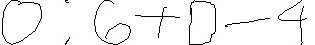

2*5+0-8 [1, 3, 1, 5, 3, -1, 5] 2


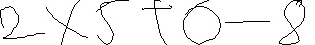

8*2-0+1 [1, 3, 1, 5, 3, -1, 5] 17


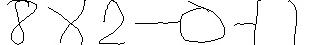

8*5-2 [1, 3, 1, -1, 3] 38


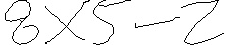

0*1*0 [1, 3, 1, -1, 3] 0


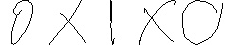

val 11325 978
7*4!+2/1 [1, 4, 3, 1, -1, 6, 4, 6] 170


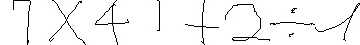

8/3/8 [1, 3, 1, -1, 3] 1


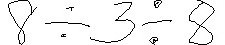

1/8*2*6+4*8+8 [1, 3, 1, 5, 3, 7, 5, 11, 9, 7, 9, -1, 11] 52


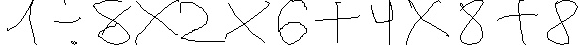

6*6+8+0/4-5*1! [1, 3, 1, 5, 3, 9, 7, 5, 7, -1, 11, 9, 13, 11] 39


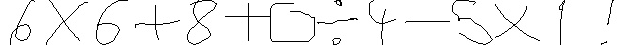

2+9-1/8/3-2-5! [1, 3, 1, 9, 5, 7, 5, 3, 7, 11, 9, -1, 13, 11] 0


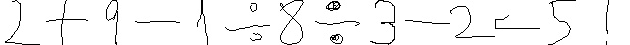

test 113250 978
7-0/7*9 [1, -1, 3, 5, 3, 1, 5] 7


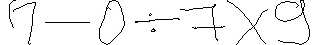

9/7-4/9+8*1!!-3+5 [1, 3, 1, 7, 5, 3, 5, 13, 9, 7, 11, 12, 9, 15, 13, -1, 15] 11


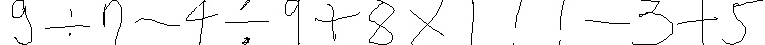

1/2/8-2+2 [1, 3, 1, 5, 3, 7, 5, -1, 7] 2


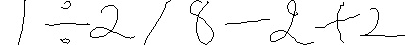

2/1 [1, -1, 1] 2


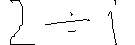

4+3/9 [1, -1, 3, 1, 3] 5


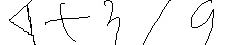

In [10]:
# Visualize data
import numpy as np
for split in splits:
    dataset = split2dataset[split]
    print(split, len(dataset), np.max([x['res'] for x in dataset]))
    for _ in range(5):
        sample = random.choice(dataset)
        img_paths = sample['img_paths']
        img = render_img(img_paths)
        print("".join(sample['expr']), sample['head'], sample['res'])
        display(img)

In [11]:
for split in splits:
    json.dump(split2dataset[split], open('expr_%s.json'%split, 'w'))

7/1/7-2 = -1.0


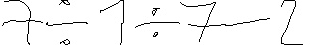

In [14]:
img = Image.open(symbol_images_dir + '2/2_849.jpg')
print(img.size)
display(img)

expr = '7/1/7-2'
img_paths = generate_img_paths(expr, sym_set=sym_set)
img = render_img(img_paths)
print(expr,'=', eval(expr))
display(img)